# Demo:  Prostate Cancer Analysis with LASSO and Other Feature Selection Methods

In this demo, we illustrate the classic technique of **LASSO regularization** and other feature selection methdos for model (feature) selection.  You will learn to:
* Fit a LASSO model using the `sklearn` package
* Determine the regularization level with cross-validation
* Draw the coefficient path as a function of the regularization level
* Try out other feature selection methods in `sklearn`

### Background

We use a classic prostate cancer dataset from the paper:

> Stamey, Thomas A., et al. "[Prostate specific antigen in the diagnosis and treatment of adenocarcinoma of the prostate. II. Radical prostatectomy treated patients](http://www.sciencedirect.com/science/article/pii/S002253471741175X)." The Journal of urology 141.5 (1989): 1076-1083.

In the study, **the level of [prostate specific antigen](https://en.wikipedia.org/wiki/Prostate-specific_antigen)** was measured in 102 men before they had a prostatectomy. Elevated values of the PSA are believed to be associated with the presence of prostate cancer and other disorders. To study this hypothesis, various features of the prostate were measured after the prostatectomy.  Data analysis is then used to understand the relation between the PSA level and prostate features.  The study is old and much more is known about PSA today.  But, the analysis is typical for medical problems and illustrates the basic tools well.

The specific analysis presented in this demo taken from the class text: 

> Friedman, Jerome, Trevor Hastie, and Robert Tibshirani. [Elements of statistical learning](https://www.amazon.com/exec/obidos/ASIN/0387952845/trevorhastie-20), New York: Springer series in statistics, 2001.

The text provides an excellent discussion of LASSO and other methods on this dataset.  

Special thanks to [Phil Schniter](http://www2.ece.ohio-state.edu/~schniter/) at Ohio State for pointing on error in an earlier version of this demo.

First, we load the regular packages.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the Data

Our analysis begins by getting the data from Tibshirani's website.   

In [7]:
# Get data
url = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data'
df = pd.read_csv(url, sep='\t', header=0)
df = df.drop('Unnamed: 0', axis=1)   # skip the column of indices

In this data set, the target variable is `lpsa`, the log of the PSA. The goal is to try  to predict the `lpsa` from various prostate features.

In [71]:
# Print the names of the target and predictor
names = df.columns.tolist()
names_x = names[0:7]
name_y = names[8]


# Convert the dataframe values to data matrices
X0 = np.array(df[names_x])
y0 = np.array(df[name_y])

#### Data Cleaning

- When performing any regularized estimate, it is critical to standardize the values.  

- For this purpose, we use `sklearn` built-in `scale` command, which makes each feature / label to have zero mean and unit standard deviation.

In [72]:
import sklearn.preprocessing

X = sklearn.preprocessing.scale(X0)
y = sklearn.preprocessing.scale(y0)


#### Adding "bad" features

- noise: a vector randomly sampled from the standard normal distribution
- redundant: exactly same as lcp
- dependent: lcp + gleason

In [73]:
random_noise = np.random.randn(X.shape[0])
redundant_feature = X[:,5]
dependent_feature = X[:,5]+X[:,6]
X = np.concatenate([X, random_noise.reshape(-1,1), 
                    redaundent_feature.reshape(-1,1),
                    dependent_feature.reshape(-1,1)], axis=1)
names_x = names_x + ["noise", "redundant", "dependent"]

In [74]:
# Print the number of samples and features
nsamp = X0.shape[0]
nfeatures = X.shape[1]
print("Target variable: %s" % name_y)
print("Predictors:     "+str(names_x))
print("")
print("num samples = %d,  num features = %d" % (nsamp, nfeatures))

Target variable: lpsa
Predictors:     ['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'noise', 'redundant', 'dependent']

num samples = 97,  num features = 10


## Fit a Linear Model with No Regularization

First, we try to fit a multiple linear model with no regularization.  We begin by importing the appropriate package.

In [56]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

We next split the data into training and test -- will use roughly half the samples for each.

In [58]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X,y,test_size=0.5,shuffle=True)
ntr = X_tr.shape[0]
nts = X_ts.shape[0]
print("num samples train = %d, test = %d" % (ntr, nts))

num samples train = 48, test = 49


Fit the model on the training data.

In [59]:
regr = linear_model.LinearRegression()
regr.fit(X_tr,y_tr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Now, we can measure the normalized RSS on the training data.  

In [60]:
# Measure normalized RSS
y_tr_pred = regr.predict(X_tr)
rsq_tr = 1-np.mean((y_tr_pred-y_tr)**2)/(np.std(y_tr)**2)
print("R^2 training = %f" % rsq_tr)

R^2 training = 0.744114


Ths `R^2` value is about `0.74`.  However, we need to evaluate the model on the test data.  

In [61]:
y_ts_pred = regr.predict(X_ts)
rss_ts = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
rsq_ts = 1-rss_ts
print("Normalized test RSS = %f" % rss_ts)
print("Normalized test R^2 = %f" % rsq_ts)

Normalized test RSS = 0.637294
Normalized test R^2 = 0.362706


We can also plot the actual vs. predicted values.  We see a clear fit.

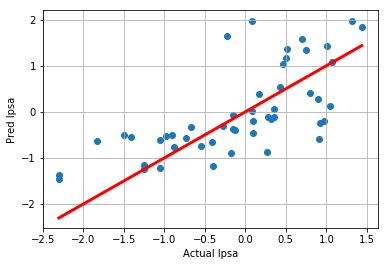

In [62]:
plt.scatter(y_ts,y_ts_pred)
plt.xlabel('Actual lpsa')
plt.ylabel('Pred lpsa')
ymin = np.min(y_ts)
ymax = np.max(y_ts)
plt.plot([ymin,ymax], [ymin,ymax], 'r-', linewidth=3)
plt.grid()
plt.show()

We can also plot the coefficients in the regression model.  Remember that all the parameters are normalized so that the coefficients can be compared.  We see that `lcavol` has the highest weight, but there are non-zero weights on all the predictors.  This makes it hard to see if other factors are significant or not. 

    lcavol    0.4532
   lweight    0.2550
       age    0.0010
      lbph    0.0462
       svi    0.5804
       lcp   -0.0834
   gleason    0.1023
     noise    0.0079
 redundant   -0.0834
 dependent    0.0189
     noise    0.0774
 redundant   -0.0834
 dependent    0.0189


<StemContainer object of 3 artists>

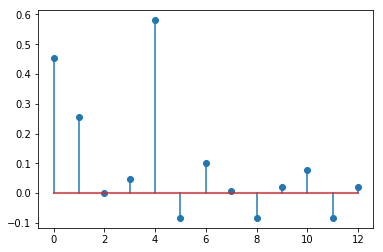

In [63]:
w = regr.coef_
for name, wi in zip(names_x, w):
    print('%10s %9.4f' % (name, wi))
    
plt.stem(w)    

## LASSO:  Linear Model with L1 Regularization

The failure of the linear model motivates us to use regularization to try to select only the "useful" features.  We will demonstrate how to use the Lasso technique.  The `sklearn` package has several excellent routines for this.  We first import the `model_selection` sub-package for the k-fold cross validation.

In [64]:
import  sklearn.model_selection 

When considering the LASSO, we consider a set of models with different levels of regularization `alpha`.  Higher values of `alpha` imply greater regularization.  Similar to the [polynomial example](./polyfit.ipynb), we use k-fold cross validation to determine the appropriate `alpha`.  That is, for each `alpha` value, we evaluate the test error on different training / tests spilt.   For larger data sets, this exhaustive search is time-consuming.  But, it should finish very fast for this small set. 

In [65]:
# Create a k-fold cross validation object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-3,1,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(X)):
        
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X[Itr,:]
    y_tr = y[Itr]
    X_ts = X[Its,:]
    y_ts = y[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Create a LASSO model object
        model = linear_model.Lasso(alpha=a)
        
        # Fit the model on the training data
        model.fit(X_tr,y_tr)
        
        # Compute the prediction error on the test data
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)

We now plot the test MSE as a function of the regularization parameter.

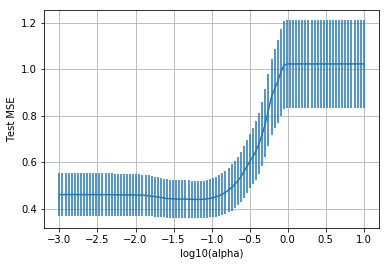

In [66]:
# Compute the mean and standard deviation over the different folds.
mse_mean = np.mean(mse,axis=1)
mse_se = np.std(mse,axis=1) / np.sqrt(nfold-1)

# Plot the mean MSE and the mean MSE with 1 SE error bars
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

We find the optimal `alpha`, by the following steps:
* Find the `alpha` with the minimum test MSE
* Set `mse_tgt = ` minimum MSE + 1 std dev MSE
* Find the least complex model (highest `alpha`) such that `MSE < mse_tgt`

Optimal alpha = 0.200923


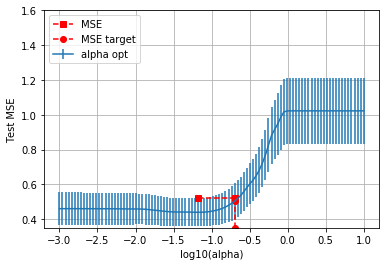

In [67]:
# Find the minimum MSE and MSE target
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_se[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

# Plot the mean MSE and the mean MSE + 1 SE errorbars 
plt.errorbar(np.log10(alphas), mse_mean, yerr=mse_se)

# Plot the MSE target
amin_log = np.log10(alpha_min)
aopt_log = np.log10(alpha_opt)
plt.plot([amin_log,aopt_log], [mse_tgt,mse_tgt], 'rs--')

# Plot the optimal alpha line
plt.plot([aopt_log,aopt_log], [0.35,mse_mean[iopt]], 'ro--')

plt.legend(['MSE', 'MSE target','alpha opt'],loc='upper left')
plt.xlabel('log10(alpha)')
plt.ylabel('Test MSE')
plt.ylim([0.35,1.6])
plt.grid()
plt.show()


Finally, we recompute the coefficients using all the training data at the correct alpha.  We see that the model selects three non-zero cofficients:  `lcavol`, `lweight` and `svi` (description of the features can be found in  https://rafalab.github.io/pages/649/prostate.html).  These features are presumably the most relevant in determining the PSA level.  Interestingly, the first feature -- `lcavol` -- is the log of the cancer volume suggesting that the cancer volume does indeed influence the PSA level.

In [68]:
model.alpha = alpha_opt
model.fit(X,y)

# Print the coefficients
for i, c in enumerate(model.coef_):
    print("%8s %f" % (names_x[i], c))

  lcavol 0.401623
 lweight 0.095029
     age 0.000000
    lbph 0.000000
     svi 0.076857
     lcp 0.000000
 gleason 0.000000
   noise -0.000000
redundant 0.000000
dependent 0.057626
   noise 0.000000
redundant 0.000000
dependent 0.000000


Using the three chosen features, we now use linear regression method directly with cross validation to evaluate the test error and  to determine the mean regression coefficients.

In [69]:
# Find coefficients greater than a small threshold
Isel = np.where(np.abs(model.coef_) > 1e-3)[0]


# Select those features
X1=X[:,Isel]
nfea1 = len(Isel)

# Run 10-fold validation with reduced feature matrix
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# MSE for each alpha and fold value
RSS_ts = np.zeros((nfold,1))
coef=np.zeros((nfold,nfea1))
for ifold, ind in enumerate(kf.split(X1)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X1[Itr,:]
    y_tr = y[Itr]
    X_ts = X1[Its,:]
    y_ts = y[Its]
    
    regr.fit(X_tr,y_tr)
    y_ts_pred = regr.predict(X_ts)
    RSS_ts[ifold] = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
    coef[ifold]=regr.coef_
            
mse_mean = np.mean(RSS_ts,axis=0)
mse_se = np.std(RSS_ts,axis=0) / np.sqrt(nfold-1)
coef_mean=np.mean(coef,axis=0)
print("mse_mean=%f mse SE=%f" % (mse_mean, mse_se))
print(coef_mean)


mse_mean=0.825434 mse SE=0.223698
[0.51911878 0.24720826 0.2263261  0.02136793]


## LASSO path

To further illustrate the effect of regularization, we conclude by drawing the *LASSO path*.  This is simply a plot of the coefficients as a function of the regularization `alpha`.  We do not need to do this for the analysis, but the path demonstrates the effect of regularization well. 


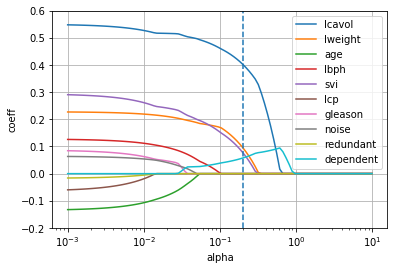

In [75]:
alphas1, coeffs, _ = sklearn.linear_model.lasso_path(X, y, alphas=alphas)

# Plot the paths of the coefficients
plt.semilogx(alphas1,coeffs.T)
plt.grid()
plt.legend(names_x, loc='upper right')


# Plot a line on the optimal alpha
plt.semilogx([alpha_opt,alpha_opt], [-0.2,0.6], '--')
plt.ylim([-0.2,0.6])
plt.xlabel('alpha')
plt.ylabel('coeff')
plt.show()



# Feature ranking methods

## Correlation, F-test and Mutual Information (MI)

Now we try feature ranking based on correlation coefficient, F-test, and mutual information. We write our own function for computing correlation coefficient between a feature and the target. We use the built-in function in sklearn feature_selection package to compute F score and MI.  f_regression evaluates the F-test (F-test = (r^2/(1-r^2)*(nsamples-2), where r is the correlation coefficient). mutual_info_regression evaluates the mutual information between each feature and the target. 

In [18]:
from sklearn.feature_selection import f_regression, mutual_info_regression

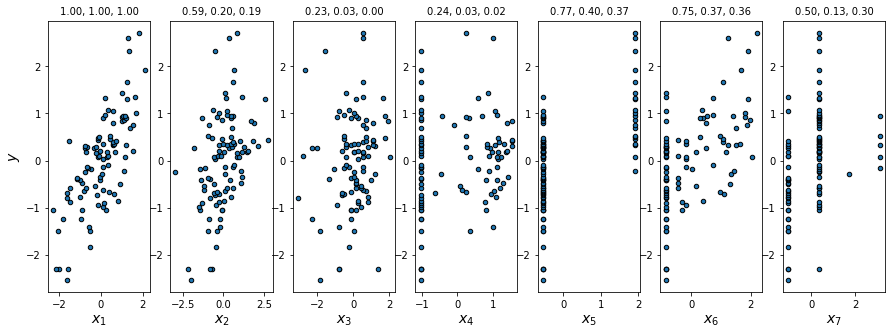

In [19]:

f_test, _ = f_regression(X, y)
f_test /= np.max(f_test)

mi = mutual_info_regression(X, y)
mi /= np.max(mi)

corr=np.zeros((nfeatures,1))
for i in range(7):
    corr[i]=np.mean(X[:,i]*y)
    # note that because X and y have both been normalized, we do not need to normalize the correlation by their STD 
    
corr=corr/np.max(corr)
    
plt.figure(figsize=(15, 5))
for i in range(7):
    plt.subplot(1, 7, i + 1)
    plt.scatter(X[:, i], y, edgecolor='black', s=20)
    plt.xlabel("$x_{}$".format(i + 1), fontsize=14)
    if i == 0:
        plt.ylabel("$y$", fontsize=14)
    plt.title("%4.2f, %4.2f, %4.2f" % (corr[i], f_test[i], mi[i]),
             fontsize=10)
plt.show()

From above figure, using ranking based on either correlation, F-test, or mutual information, the top three features are x1, x5, and x6. We will now try to use these three features to train a multi linear regressor and compare with the results obtained with LASSO using x1, x2, and x5. We will use cross validation to estimate the test error

In [20]:
X1=np.zeros((nsamp, 3))
X1[:,0]=X[:,0]
X1[:,1]=X[:,4]
X1[:,2]=X[:,5]

In [21]:
regr = linear_model.LinearRegression()
regr.fit(X1,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [22]:
nfold = 10
nfea1 = 3;
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# MSE for each alpha and fold value
RSS_ts = np.zeros((nfold,1))
coef=np.zeros((nfold,nfea1))
for ifold, ind in enumerate(kf.split(X1)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    X_tr = X1[Itr,:]
    y_tr = y[Itr]
    X_ts = X1[Its,:]
    y_ts = y[Its]
    
    regr.fit(X_tr,y_tr)
    y_ts_pred = regr.predict(X_ts)
    RSS_ts[ifold] = np.mean((y_ts_pred-y_ts)**2)/(np.std(y_ts)**2)
    coef[ifold]=regr.coef_
            
mse_mean = np.mean(RSS_ts,axis=0)
mse_std = np.std(RSS_ts,axis=0) / np.sqrt(nfold-1)
coef_mean=np.mean(coef,axis=0)
print("mse_mean=%f mse_std=%f" % (mse_mean, mse_std))
print(coef_mean)

mse_mean=0.532789 mse_std=0.045213
[ 0.62701377  0.26342577 -0.05191608]


We see that in this case, features found by LASSO lead to smaller test error. Note that the mse_mean derived in each case depends on the random shuffling used in generating the multiple folds, so each time the values may be different. Some times, using the features determined by the ranking method could lead to smaller mse. 


##  Recursive feature elimination (RFE)
RFE is a method to select the features by recursively considering smaller and smaller sets of features. It first fits the multi-linear regression with all the features and evaluates the importance of each feature using the `coef_` attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached. See http://scikit-learn.org/stable/modules/feature_selection.html#recursive-feature-elimination for details.


In [23]:
from sklearn.feature_selection import RFE

In [24]:
regr = linear_model.LinearRegression()
rfe = RFE(estimator=regr, n_features_to_select=1, step=1)
rfe.fit(X,y)
ranking = rfe.ranking_
print(ranking)

[1 2 5 4 3 7 6]


We see that the top 3 features are x1, x2, and x5 which is the same as the lasso. 